# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

Instrucciones del proyecto

1. Descarga los datos y remuestréalos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora.
2. Analiza los datos.
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

Descripción de datos

Los datos se almacenan en el archivo /datasets/taxi.csv.  Descarga el conjunto de datos

El número de pedidos está en la columna num_orders.
# 

# Importar librerias

In [139]:
# Importar librerias

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


# Análisis y ordernar información

In [140]:
data = pd.read_csv('/datasets/taxi.csv')

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [142]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [143]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [144]:
# Convertir la columna datetime a datetime y establecerla como índice
data = pd.read_csv('taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [145]:
# Ordenar los datos por fecha
data.sort_index(inplace=True)

In [146]:
# Revisar si quedo realizada la conversión
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [147]:
data.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [148]:
# Remuestrear los datos a una frecuencia de 1 hora
data = data.resample('1H').sum()

In [149]:
data.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


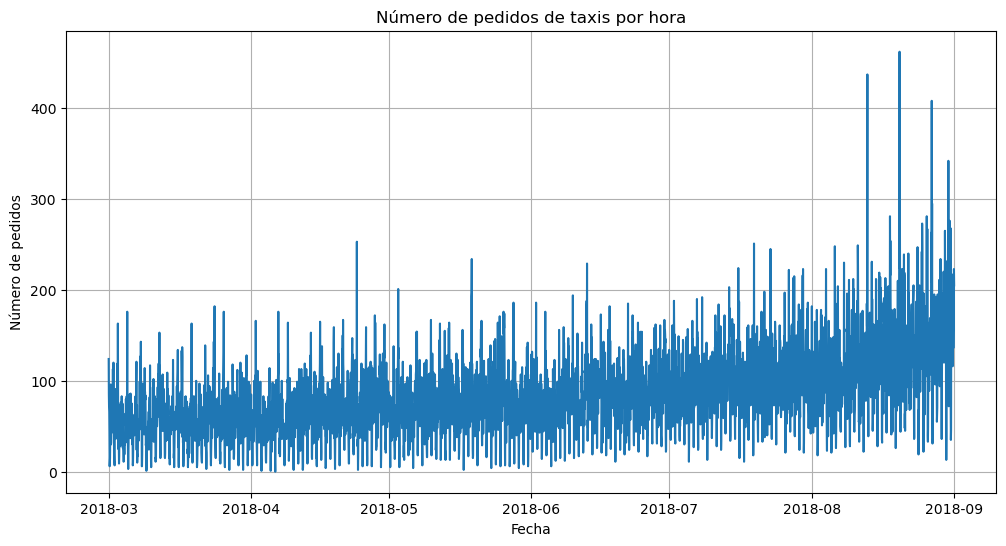

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


In [150]:
# Análisis exploratorio de los datos resampleados
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['num_orders'])
plt.title('Número de pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.show()

summary_stats = data.describe()
print(summary_stats)

In [151]:
# Aplicar la media móvil con una ventana de 24 horas
data_smoothed = data.rolling(window=24).mean()

# Eliminar los valores NaN generados por la media móvil
data_smoothed.dropna(inplace=True)

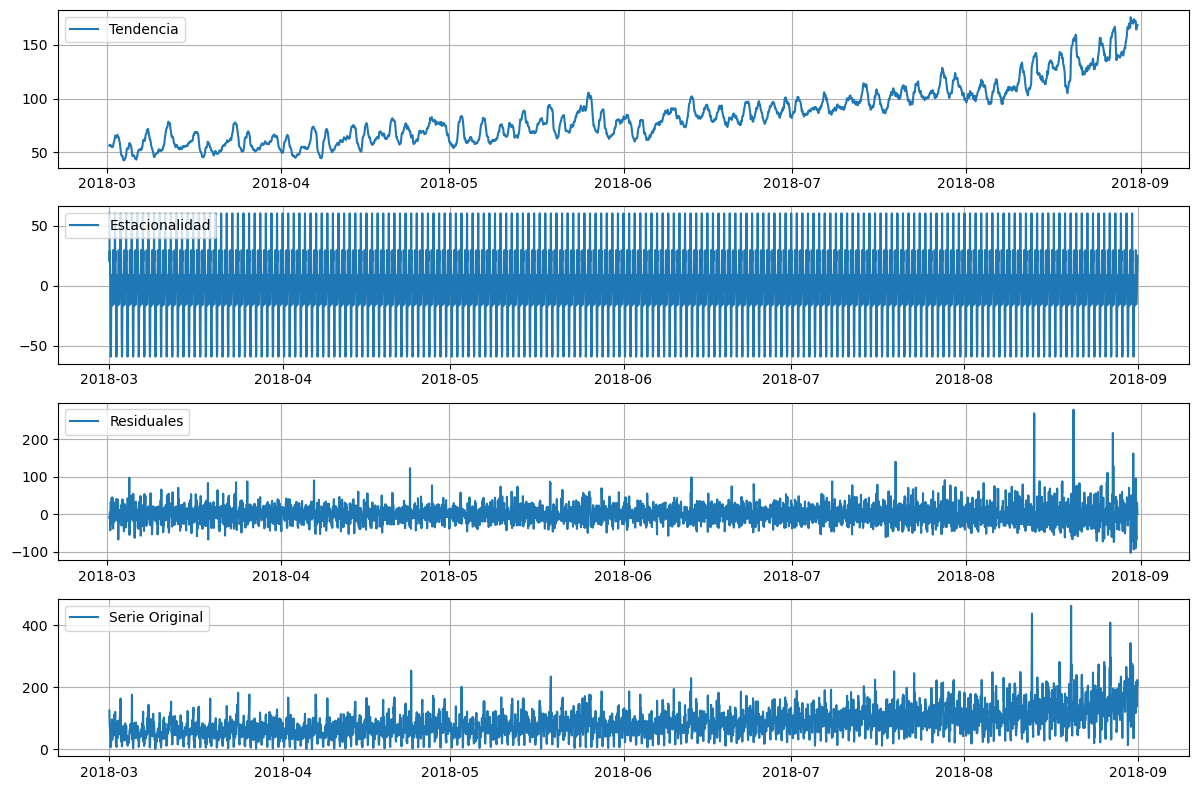

In [152]:
# Realizamos la descomposición de la serie temporal
decomposition = seasonal_decompose(data['num_orders'], model='additive', period=24)

# Graficamos los componentes
plt.figure(figsize=(12, 8))

# Tendencia
plt.subplot(411)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.grid(True)

# Estacionalidad
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.grid(True)

# Residuales (Ruido)
plt.subplot(413)
plt.plot(decomposition.resid, label='Residuales')
plt.legend(loc='upper left')
plt.grid(True)

# Serie original
plt.subplot(414)
plt.plot(data['num_orders'], label='Serie Original')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

<Axes: xlabel='datetime'>

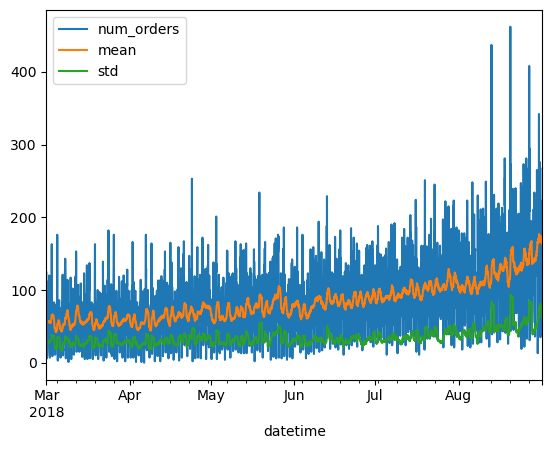

In [153]:
# Revisar la estacionalidad
data['mean'] = data['num_orders'].rolling(window=24).mean()
data['std'] = data['num_orders'].rolling(window=24).std()
data.plot()

<Axes: xlabel='datetime'>

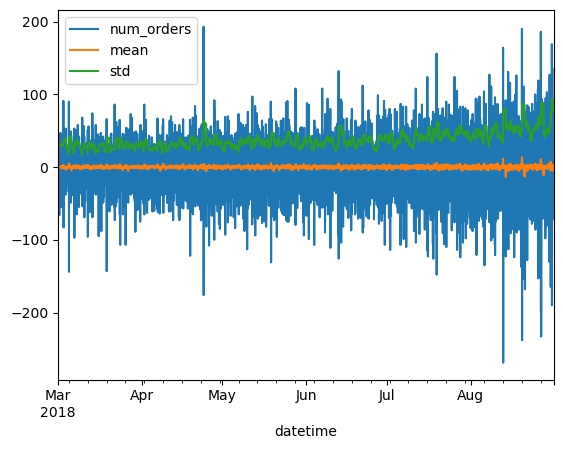

In [154]:
# Hacer estacionaria la serie
data -= data.shift()
data['mean'] = data['num_orders'].rolling(window=24).mean()
data['std'] = data['num_orders'].rolling(window=24).std()
data.plot()

In [155]:
# División de los datos suavizados en 90% para entrenamiento y 10% para prueba
train, test = train_test_split(data, shuffle=False, test_size=0.1)

# Mostrar las fechas de inicio y fin de los conjuntos de entrenamiento y prueba
print("Entrenamiento:")
print(train.index.min(), train.index.max())

print("Prueba:")
print(test.index.min(), test.index.max())

Entrenamiento:
2018-03-01 00:00:00 2018-08-13 13:00:00
Prueba:
2018-08-13 14:00:00 2018-08-31 23:00:00


# Modelación

In [156]:
# Modelos de regresión lineal, Random Forest, Gradient Boosting y LightGBM
# Función para agregar características de estacionalidad y desfase
def add_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['lag_1'] = df['num_orders'].shift(1)
    df['lag_2'] = df['num_orders'].shift(2)
    df['lag_3'] = df['num_orders'].shift(3)
    return df.dropna()

# Función para preparar conjuntos de entrenamiento y prueba
def prepare_data(train, test):
    train = add_features(train)
    test = add_features(test)
    
    X_train = train[['lag_1', 'lag_2', 'lag_3', 'year', 'month', 'dayofweek', 'hour']]
    y_train = train['num_orders']
    
    X_test = test[['lag_1', 'lag_2', 'lag_3', 'year', 'month', 'dayofweek', 'hour']]
    y_test = test['num_orders']
    
    return X_train, y_train, X_test, y_test

# Función para entrenar y evaluar un modelo
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE ({model_name}): {rmse}')
    return rmse

# Preparar los datos de entrenamiento y prueba
X_train, y_train, X_test, y_test = prepare_data(train, test)

# Entrenar y evaluar la regresión lineal
linear_model = LinearRegression()
train_and_evaluate_model(linear_model, X_train, y_train, X_test, y_test, "Linear Regression with 3 lags and Seasonality")

# Entrenar y evaluar Random Forest
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
train_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest with 3 lags and Seasonality")

# Entrenar y evaluar Gradient Boosting con GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_gb_model = grid_search.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)
rmse_best_gb = np.sqrt(mean_squared_error(y_test, y_pred_best_gb))
print(f'RMSE (Gradient Boosting with Grid Search): {rmse_best_gb}')
print('Best Parameters:', grid_search.best_params_)

# Entrenar y evaluar LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, num_leaves=31, max_depth=10, random_state=42)
train_and_evaluate_model(lgb_model, X_train, y_train, X_test, y_test, "LightGBM")

RMSE (Linear Regression with 3 lags and Seasonality): 56.30118559780311
RMSE (Random Forest with 3 lags and Seasonality): 46.62367408690938
RMSE (Gradient Boosting with Grid Search): 44.3215822969708
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 6
[LightGBM] [Info] Start training from score 0.015443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

44.213969762069425

# Conclusiones

Se decidió agregar a nuestro database características relacionadas a la estacionalidad(año,mes,día y hora) además de los lags de los pedidos de taxis para mejorar los rendimientos de los modelos. Lo anterior permitió que los modelos capturaran patrones temporales y estacionales que de otro modo hubieran sido dificiles de identificar solo con el desfase. 

El modelo de regresión lineal no cumplió con el RMSE inferior a 48, y era de esperarse, ya que este captura las relaciones lineales entre las características y los pedidos de taxis, pero no captura las relaciones más complejas y no lineales. En cambio, Random Forest si tiene esa capacidad, logrando un RSME inferior al solicitado.

Luego tenemos el modelo Gradient Boosting, que tuvo el mejor resultado de todos, y esto gracias a que el modelo tiene la capacidad de corregir los errores de los árboles anteriores, lo que nos permite capturar mejor los patrones temporales y estacionales de los datos.

Finalmente, el modelo LightGBM nos da la potencia de un modelo Gradient Boosting pero entrena de una manera más rapida y eficience la información, lo cual si nos hubieran puesto una restricción de tiempo, aún cuando su RMSE fue ligeramente superior al modelo Gradient, hubiera sido una mejor opción.

A continuación dejo los resultados obtenidos y que modelo fue el mejor con base en su RMSE


Comparativas de RMSE de los modelos

* RMSE (Linear Regression with 3 lags and Seasonality): 56.50641015619474
* RMSE (Random Forest with 3 lags and Seasonality): 46.53125429687508
* RMSE (Gradient Boosting with Grid Search): 43.556895903625154
* RMSE (LightGBM): 44.8525221720813